In [33]:
#Imports
import numpy as np
import pandas as pd
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import seaborn as sns
pd.options.display.max_columns = 50
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV, ElasticNet, Lasso
from sklearn.cross_validation import cross_val_score
import xgboost as xgb

In [34]:
#importing data
train_DF = pd.read_csv('train.csv')
test_DF = pd.read_csv('test.csv')
train_DF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,...,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,...,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,...,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [35]:
print("------Training Data Information-------\n")
train_DF.info()
print("\n\n------Test Data Information-------\n")
test_DF.info()

------Training Data Information-------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non

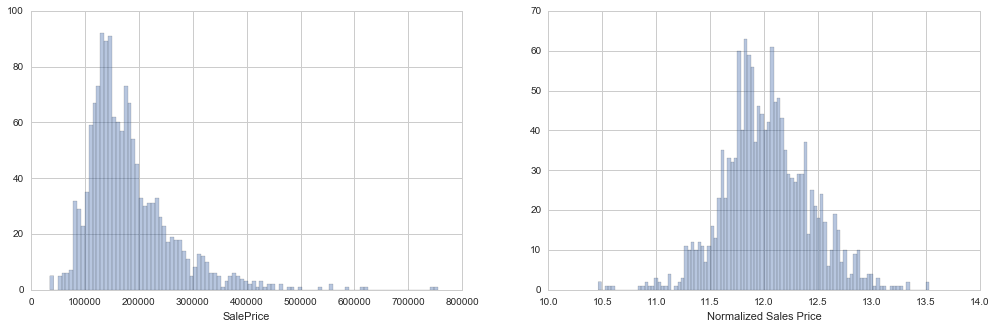

In [36]:
#Plot a general distribution of the prices (Fixing the skewed meytSkewed Metric)
figure, (ax1, ax2) = plt.subplots(1,2,figsize = (17,5))
sns.distplot(train_DF['SalePrice'], kde = False, ax = ax1, bins = 100)
sns.distplot(np.log1p(train_DF["SalePrice"]), kde = False, axlabel = 'Normalized Sales Price', ax = ax2, bins = 100)
train_DF['SalePrice'] = np.log1p(train_DF["SalePrice"])

In [37]:
#fixing other numeric skewed metrics
numeric_features_train = train_DF.dtypes[train_DF.dtypes != 'object'].index
numeric_features_test = test_DF.dtypes[train_DF.dtypes != 'object'].index

skewed_features_train = train_DF[numeric_features_train].apply(lambda x: skew(x))
skewed_features_test = test_DF[numeric_features_test].apply(lambda x: skew(x))

skewed_features_train = skewed_features_train[skewed_features_train > 0.75]
skewed_features_test = skewed_features_test[skewed_features_test > 0.75]
skewed_features_train = skewed_features_train.index
skewed_features_test = skewed_features_test.index

train_DF[skewed_features_train] = np.log1p(train_DF[skewed_features_train])
test_DF[skewed_features_test] = np.log1p(test_DF[skewed_features_test])

In [38]:
train_DF.head() #Always a good practise to keep a check on the operating dataframe every once in while

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,4.110874,RL,65.0,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,...,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal,12.247699
1,2,3.044522,RL,80.0,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,...,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal,12.109016
2,3,4.110874,RL,68.0,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal,12.317171
3,4,4.262680,RL,60.0,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,...,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml,11.849405
4,5,4.110874,RL,84.0,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal,12.429220


In [39]:
#Getting dummies for all the non numeric data
train_DF = pd.get_dummies(train_DF)
test_DF = pd.get_dummies(test_DF)

#Fill in empty values with mean of each column
train_DF = train_DF.fillna(train_DF.mean())
test_DF = test_DF.fillna(test_DF.mean())

In [40]:
#Classifying training and test data
X = train_DF.drop(['Id','SalePrice'], axis = 1, inplace = False)
Y = train_DF['SalePrice']
X_test = test_DF.drop('Id', axis = 1, inplace = False)
X.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,...,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,65.0,9.042040,7,5,2003,2003,196.0,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,1,0.000000,2,1,3,0.693147,8,0,2003.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.044522,80.0,9.169623,6,8,1976,1976,0.0,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0,0.693147,2,0,3,0.693147,6,1,1976.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.110874,68.0,9.328212,7,5,2001,2002,162.0,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,1,0.000000,2,1,3,0.693147,6,1,2001.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
#Define function for determining Tuning Parameter
def cv_error(model):
    cve= np.sqrt(-cross_val_score(model, X, Y, scoring="mean_squared_error", cv = 5))
    return(cve)

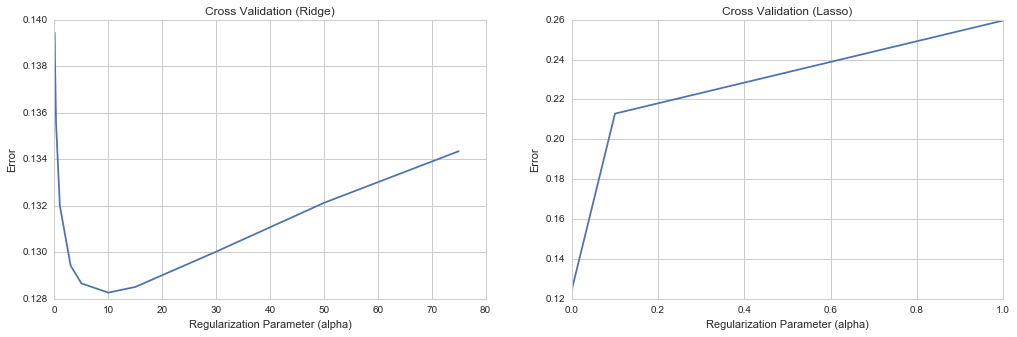

In [42]:
#Ridge
a_ridge = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cvScores_ridge = [cv_error(Ridge(alpha = alpha)).mean() for alpha in a_ridge]
cvScores_ridge = pd.Series(cvScores_ridge, index = a_ridge)
minimum_error = cvScores_ridge.min()

#Lasso
a_lasso = [1, 0.1, 0.001, 0.0005]
cvScores_lasso = [cv_error(Lasso(alpha = alpha)).mean() for alpha in a_lasso]
cvScores_lasso = pd.Series(cvScores_lasso, index = a_lasso)
minimum_error_lasso = cvScores_lasso.min()

#Plots
figure, (ax1, ax2) = plt.subplots(1,2,figsize = (17,5))
ax1.plot(cvScores_ridge)
ax1.set_title("Cross Validation (Ridge)")
ax1.set_xlabel("Regularization Parameter (alpha)")
ax1.set_ylabel("Error")
ax2.plot(cvScores_lasso)
ax2.set_title("Cross Validation (Lasso)")
ax2.set_xlabel("Regularization Parameter (alpha)")
ax2.set_ylabel("Error")

In [46]:
print("Minimum Error for Ridge Model: ", minimum_error)
print("Minimum Error for Lasso Model: ", minimum_error_lasso)
def ord_to_char(v, p=None):
    return chr(int(v))

Minimum Error for Ridge Model:  0.128263112374
Minimum Error for Lasso Model:  0.12346064433


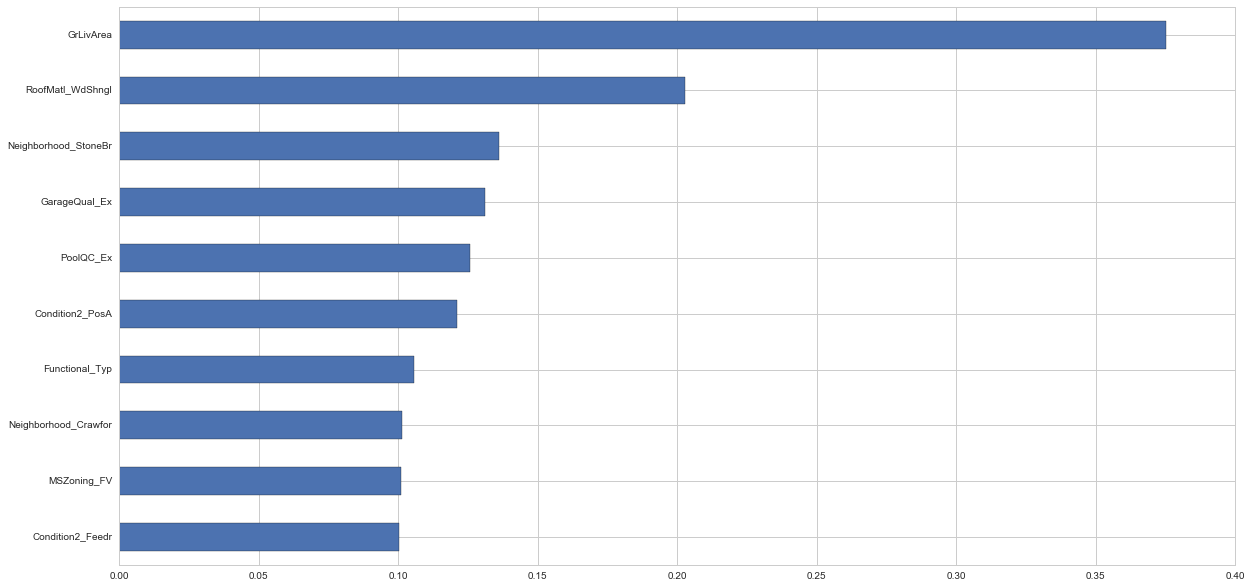

In [49]:
#Picking up Ridge Model & figuring 10 most useful and 10 least useful parameters for Housing Price Prediction
ridgeReg = Ridge()
ridgeReg.fit(X,Y)
coef = pd.Series(ridgeReg.coef_, index = X.columns)
relevant_Coeff = coef.sort_values().tail(10)
irrelevant_Coeff = coef.sort_values().head(10)

#Plots
plt.figure(figsize=(20,10))
relevant_Coeff.plot(kind = "barh")

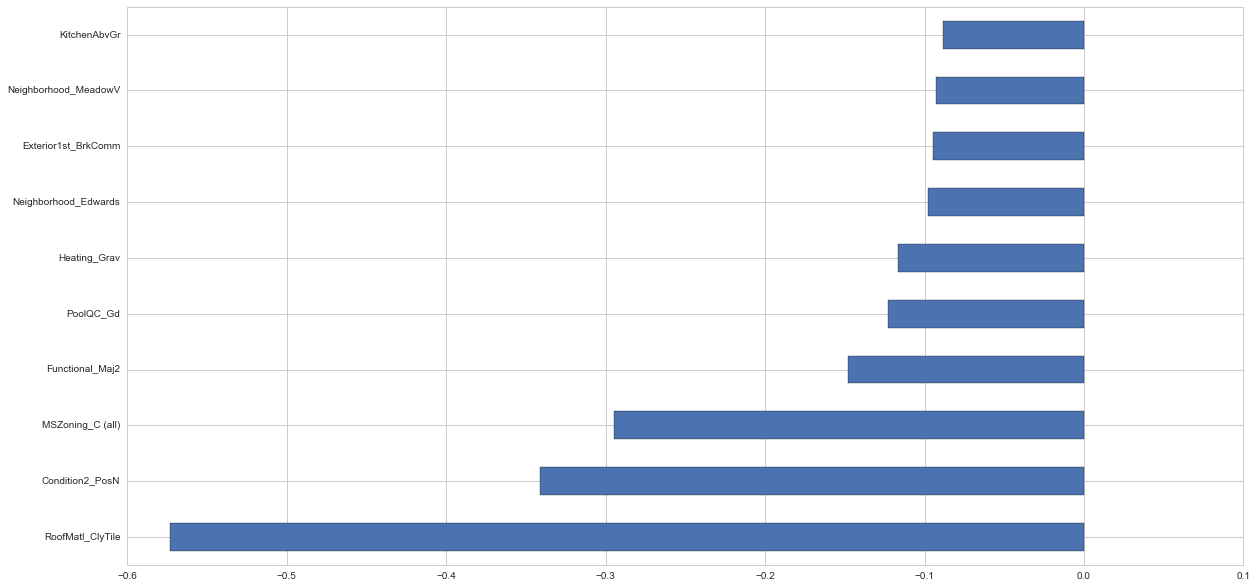

In [51]:
plt.figure(figsize=(20,10))
irrelevant_Coeff.plot(kind = 'barh')